In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Data Analysis

# By County Analysis

In [3]:
# Connect SQLite.
dbconn = sqlite3.connect('../data/IowaLiquorSales.db')
cursor = dbconn.cursor()

# Pull Store database.
query = '''SELECT Sales.TransactionID, Sales.Date, Sales.StoreID, Sales.ProductID, Sales.VendorID, Store.County, Store.lat, Store.lng, County.Year, County.Population, County.UNEMPLOYMENT_RATE, Sales.VolumeSold_Liters, Sales.Sale_Dollars
              FROM ((Sales 
              INNER JOIN Store ON Sales.StoreID=Store.StoreID)
              INNER JOIN County ON County.County=Store.County)
              WHERE Sales.Date BETWEEN '2021-01-01' AND '2021-12-31' 
              AND County.Year = '2021';'''
cursor.execute(query)
result1 = cursor.fetchall()
cursor.close()
dbconn.close()

In [60]:
# Put the database in a data frame format.
temp1 = pd.DataFrame(result1, columns = ['TransactionID',
                                            'Date',
                                            'StoreID',
                                            'ProductID',
                                            'VendorID',
                                            'County',
                                            'lat',
                                            'lng',
                                            'Year',
                                            'Population',
                                            'Unemployment_Rate',
                                            'VolumeSold_Liters',
                                            'Sale_Dollars'])

In [61]:
temp1.head()

,TransactionID,Date,StoreID,ProductID,VendorID,County,lat,lng,Year,Population,Unemployment_Rate,VolumeSold_Liters,Sale_Dollars
0,INV-41517100002,2021-11-01,5417,36308,434,linn,41.88875,-91.67497,2021,230479,4.9,10.50,64.56
1,INV-41518800037,2021-11-01,4921,19061,65,linn,41.96451,-91.73978,2021,230479,4.9,0.05,10.50
2,INV-41518900014,2021-11-01,5687,11296,260,linn,41.96442,-91.72973,2021,230479,4.9,9.00,298.68
3,INV-41521200068,2021-11-01,2648,86250,434,polk,41.56108,-93.77478,2021,504735,4.2,9.00,48.12
4,INV-41523800012,2021-11-01,4379,52596,205,polk,41.58511,-93.78953,2021,504735,4.2,3.75,48.75


## Stores Locations Mini Table

In [62]:
map_stores0 = temp1.drop_duplicates(subset='StoreID', keep='first')
map_stores = map_stores0[['StoreID','County','lat','lng']]

In [63]:
map_stores.head()

,StoreID,County,lat,lng
0,5417,linn,41.88875,-91.67497
1,4921,linn,41.96451,-91.73978
2,5687,linn,41.96442,-91.72973
3,2648,polk,41.56108,-93.77478
4,4379,polk,41.58511,-93.78953


In [64]:
# convert the lat and lng coordinates to geometry
import geopandas as gpd
from shapely.geometry import Point, Polygon

map_stores["lat"] = map_stores["lat"].astype('float')
map_stores["lng"] = map_stores["lng"].astype('float')

geometry = [Point(xy) for xy in zip( map_stores["lng"], map_stores["lat"])]
geometry[:3]

crs = "EPSG:4326"

# create new geo-DataFrame
store_geo = gpd.GeoDataFrame(map_stores,crs = crs,
                         geometry = geometry)

/tmp/ipykernel_3984/3030766482.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_stores["lat"] = map_stores["lat"].astype('float')
/tmp/ipykernel_3984/3030766482.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_stores["lng"] = map_stores["lng"].astype('float')


In [65]:
store_geo.head()

,StoreID,County,lat,lng,geometry
0,5417,linn,41.88875,-91.67497,POINT (-91.67497 41.88875)
1,4921,linn,41.96451,-91.73978,POINT (-91.73978 41.96451)
2,5687,linn,41.96442,-91.72973,POINT (-91.72973 41.96442)
3,2648,polk,41.56108,-93.77478,POINT (-93.77478 41.56108)
4,4379,polk,41.58511,-93.78953,POINT (-93.78953 41.58511)


In [66]:
# loading county csv
county = pd.read_csv('../data/county.csv')
county.rename(columns={'UNEMPLOYMENT RATE': 'UNEMPLOYMENT_RATE'}, inplace=True)
county_2021 = county.loc[county['Year']==2021]
county_2021.head()

,County,Year,Population,Income_PerCapita,LABORFORCE,EMPLOYMENT,UNEMPLOYMENT,UNEMPLOYMENT_RATE
1089,adair,2021,6888,NaN,4300,4180,120,2.7
1090,adams,2021,3496,NaN,2010,1950,60,2.8
1091,allamakee,2021,13548,NaN,7010,6760,250,3.5
1092,appanoose,2021,12335,NaN,6060,5800,260,4.3
1093,audubon,2021,5338,NaN,3070,2970,90,3.1


In [67]:
# want income data for 2020 (since 2021 is unavailable)
county_2020 = county.loc[county['Year']==2020]
county_2020_income = county_2020[['County','Income_PerCapita']]
county_2020_income.head()

,County,Income_PerCapita
990,adair,56422.0
991,adams,59569.0
992,allamakee,51107.0
993,appanoose,42125.0
994,audubon,54313.0


In [68]:
df_bycounty_temp0 = temp1.groupby(['County']).agg({'Sale_Dollars':'sum',
                               'StoreID':'nunique',
                               'VolumeSold_Liters':'sum',
                               'ProductID':'nunique',
                               'VendorID':'nunique'})
df_bycounty_temp0.rename(columns={'Sale_Dollars': 'Annual_SalesDollars',
                            'StoreID': 'StoreCount',
                            'VolumeSold_Liters': 'Annual_VolumeSold',
                            'ProductID': 'ProductCount',
                            'VendorID': 'VendorCount'}, inplace=True)

df_bycounty_temp0.head()

,Annual_SalesDollars,StoreCount,Annual_VolumeSold,ProductCount,VendorCount
County,,,,,
adair,683600.94,8,43177.07,621,52
adams,215545.86,2,13532.61,445,48
allamakee,1091295.24,10,77669.16,1155,66
appanoose,1107116.79,9,71170.37,892,53
audubon,288076.35,4,19729.46,642,53


In [69]:
df_bycounty_temp1 = df_bycounty_temp0.merge(county_2021, on = ['County'], how = 'left')
df_bycounty_temp1['StoresPer10K'] = (df_bycounty_temp1['StoreCount']/df_bycounty_temp1['Population'])*10000
df_bycounty_temp1['SalesPerCapita'] = (df_bycounty_temp1['Annual_SalesDollars']/df_bycounty_temp1['Population'])
df_bycounty_temp1['VolSoldPerCapita'] = (df_bycounty_temp1['Annual_VolumeSold']/df_bycounty_temp1['Population'])
df_bycounty_temp1 = df_bycounty_temp1.drop(columns = ['Income_PerCapita'])
df_bycounty_temp1.head()

,County,Annual_SalesDollars,StoreCount,Annual_VolumeSold,ProductCount,VendorCount,Year,Population,LABORFORCE,EMPLOYMENT,UNEMPLOYMENT,UNEMPLOYMENT_RATE,StoresPer10K,SalesPerCapita,VolSoldPerCapita
0,adair,683600.94,8,43177.07,621,52,2021,6888,4300,4180,120,2.7,11.614402,99.245200,6.268448
1,adams,215545.86,2,13532.61,445,48,2021,3496,2010,1950,60,2.8,5.720824,61.654994,3.870884
2,allamakee,1091295.24,10,77669.16,1155,66,2021,13548,7010,6760,250,3.5,7.381163,80.550283,5.732888
3,appanoose,1107116.79,9,71170.37,892,53,2021,12335,6060,5800,260,4.3,7.296311,89.754097,5.769791
4,audubon,288076.35,4,19729.46,642,53,2021,5338,3070,2970,90,3.1,7.493443,53.967094,3.696040


In [70]:
# Adding 2020 income column
df_bycounty = df_bycounty_temp1.merge(county_2020_income, on = ['County'], how = 'left')
df_bycounty.rename(columns={'Income_PerCapita': 'Income_PerCapita_2020'}, inplace=True)
df_bycounty['SalesPerCapita_perStore'] = (df_bycounty['SalesPerCapita']/df_bycounty_temp1['StoreCount'])
df_bycounty.head()

,County,Annual_SalesDollars,StoreCount,Annual_VolumeSold,ProductCount,VendorCount,Year,Population,LABORFORCE,EMPLOYMENT,UNEMPLOYMENT,UNEMPLOYMENT_RATE,StoresPer10K,SalesPerCapita,VolSoldPerCapita,Income_PerCapita_2020,SalesPerCapita_perStore
0,adair,683600.94,8,43177.07,621,52,2021,6888,4300,4180,120,2.7,11.614402,99.245200,6.268448,56422.0,12.405650
1,adams,215545.86,2,13532.61,445,48,2021,3496,2010,1950,60,2.8,5.720824,61.654994,3.870884,59569.0,30.827497
2,allamakee,1091295.24,10,77669.16,1155,66,2021,13548,7010,6760,250,3.5,7.381163,80.550283,5.732888,51107.0,8.055028
3,appanoose,1107116.79,9,71170.37,892,53,2021,12335,6060,5800,260,4.3,7.296311,89.754097,5.769791,42125.0,9.972677
4,audubon,288076.35,4,19729.46,642,53,2021,5338,3070,2970,90,3.1,7.493443,53.967094,3.696040,54313.0,13.491774


In [71]:
df_bycounty.nlargest(5,'SalesPerCapita_perStore')

,County,Annual_SalesDollars,StoreCount,Annual_VolumeSold,ProductCount,VendorCount,Year,Population,LABORFORCE,EMPLOYMENT,UNEMPLOYMENT,UNEMPLOYMENT_RATE,StoresPer10K,SalesPerCapita,VolSoldPerCapita,Income_PerCapita_2020,SalesPerCapita_perStore
1,adams,215545.86,2,13532.61,445,48,2021,3496,2010,1950,60,2.8,5.720824,61.654994,3.870884,59569.0,30.827497
79,ringgold,267877.77,2,17330.49,483,34,2021,4840,2390,2320,80,3.2,4.132231,55.346647,3.580680,50196.0,27.673323
29,dickinson,5864449.26,18,364517.72,2179,112,2021,17463,10900,10560,350,3.2,10.307507,335.821409,20.873717,63319.0,18.656745
46,ida,724164.12,6,45961.14,1323,96,2021,6781,3990,3880,120,2.9,8.848252,106.793116,6.777930,57429.0,17.798853
58,lucas,719057.82,5,43450.38,921,57,2021,8436,4850,4720,140,2.8,5.926980,85.236821,5.150590,44707.0,17.047364


In [72]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap = plt.get_cmap('magma_r')
new_cmap = truncate_colormap(cmap, 0, 0.6)

In [73]:
# County Boundaries Shape File
map_counties = gpd.read_file(
    '../data/County_Boundaries_of_Iowa/geo_export_b0962504-4b8e-4a81-9f03-586d790445ed.shp')

map_counties.rename(columns={'county_nam': 'County'}, inplace=True)
map_counties = map_counties.sort_values(by=['County'])

map_counties['County'] = map_counties['County'].str.lower()
map_counties.loc[map_counties['County']=="obrien",'County']="o'brien"
map_counties.head()

,gnis_featu,fips,state_coun,County,acres,geometry
71,465190,19001,01,adair,364794.8,"POLYGON ((-94.70051 41.50434, -94.68163 41.504..."
80,465191,19003,02,adams,272218.7,"POLYGON ((-94.92751 41.15872, -94.91078 41.158..."
5,465192,19005,03,allamakee,421810.2,"POLYGON ((-91.61075 43.50060, -91.61061 43.500..."
97,465193,19007,04,appanoose,330047.6,"POLYGON ((-93.09759 40.89823, -93.07897 40.898..."
58,465194,19009,05,audubon,283755.1,"POLYGON ((-95.09285 41.86336, -95.07302 41.863..."


In [74]:
# County Points Shape File
map_counties_pts = gpd.read_file(
    '../data/Primary_Points_for_Iowa_Counties/geo_export_7ec5c31d-2f89-4961-bacf-1dbe5f7b3ed7.shp')

map_counties_pts.rename(columns={'county_nam': 'County'}, inplace=True)
map_counties_pts['County'] = map_counties_pts['County'].str.lower()

In [75]:
# Digging into the discrepancies (county names need to match)
temp2 = list(map_counties['County'].unique())
temp0 = list(df_bycounty['County'].unique())
s = set(temp2)
temp3 = [x for x in temp0 if x not in s]
temp3

[]

In [76]:
map_counties2 = map_counties.merge(df_bycounty, on = ['County'], how = 'left')
map_counties2.head()

,gnis_featu,fips,state_coun,County,acres,geometry,Annual_SalesDollars,StoreCount,Annual_VolumeSold,ProductCount,VendorCount,Year,Population,LABORFORCE,EMPLOYMENT,UNEMPLOYMENT,UNEMPLOYMENT_RATE,StoresPer10K,SalesPerCapita,VolSoldPerCapita,Income_PerCapita_2020,SalesPerCapita_perStore
0,465190,19001,01,adair,364794.8,"POLYGON ((-94.70051 41.50434, -94.68163 41.504...",683600.94,8,43177.07,621,52,2021,6888,4300,4180,120,2.7,11.614402,99.245200,6.268448,56422.0,12.405650
1,465191,19003,02,adams,272218.7,"POLYGON ((-94.92751 41.15872, -94.91078 41.158...",215545.86,2,13532.61,445,48,2021,3496,2010,1950,60,2.8,5.720824,61.654994,3.870884,59569.0,30.827497
2,465192,19005,03,allamakee,421810.2,"POLYGON ((-91.61075 43.50060, -91.61061 43.500...",1091295.24,10,77669.16,1155,66,2021,13548,7010,6760,250,3.5,7.381163,80.550283,5.732888,51107.0,8.055028
3,465193,19007,04,appanoose,330047.6,"POLYGON ((-93.09759 40.89823, -93.07897 40.898...",1107116.79,9,71170.37,892,53,2021,12335,6060,5800,260,4.3,7.296311,89.754097,5.769791,42125.0,9.972677
4,465194,19009,05,audubon,283755.1,"POLYGON ((-95.09285 41.86336, -95.07302 41.863...",288076.35,4,19729.46,642,53,2021,5338,3070,2970,90,3.1,7.493443,53.967094,3.696040,54313.0,13.491774


In [77]:
map_counties2.nlargest(5, 'StoreCount')['County']

76          polk
56          linn
6     black hawk
81         scott
51       johnson
Name: County, dtype: object

In [78]:
map_counties2.nlargest(5, 'Population')['County']

76          polk
56          linn
81         scott
51       johnson
6     black hawk
Name: County, dtype: object

In [79]:
map_counties2.nlargest(5, 'StoresPer10K')['County'].reset_index()

,index,County
0,70,o'brien
1,75,pocahontas
2,59,lyon
3,0,adair
4,73,palo alto


In [80]:
map_counties2.nlargest(5, 'SalesPerCapita')['County'].reset_index()

,index,County
0,29,dickinson
1,16,cerro gordo
2,76,polk
3,6,black hawk
4,81,scott


In [81]:
map_counties2.nlargest(5, 'VolSoldPerCapita')['County'].reset_index()

,index,County
0,29,dickinson
1,16,cerro gordo
2,76,polk
3,6,black hawk
4,13,carroll


In [82]:
map_counties2.nlargest(5, 'Income_PerCapita_2020')['County'].reset_index()

,index,County
0,24,dallas
1,29,dickinson
2,65,mitchell
3,17,cherokee
4,64,mills


In [83]:
map_counties2.nlargest(5, 'SalesPerCapita_perStore')['County'].reset_index()

,index,County
0,1,adams
1,79,ringgold
2,29,dickinson
3,46,ida
4,58,lucas


In [84]:
#map_counties2.nlargest(99, 'Population')['County'].reset_index()

# Map It Out

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Stores in 2021'}>

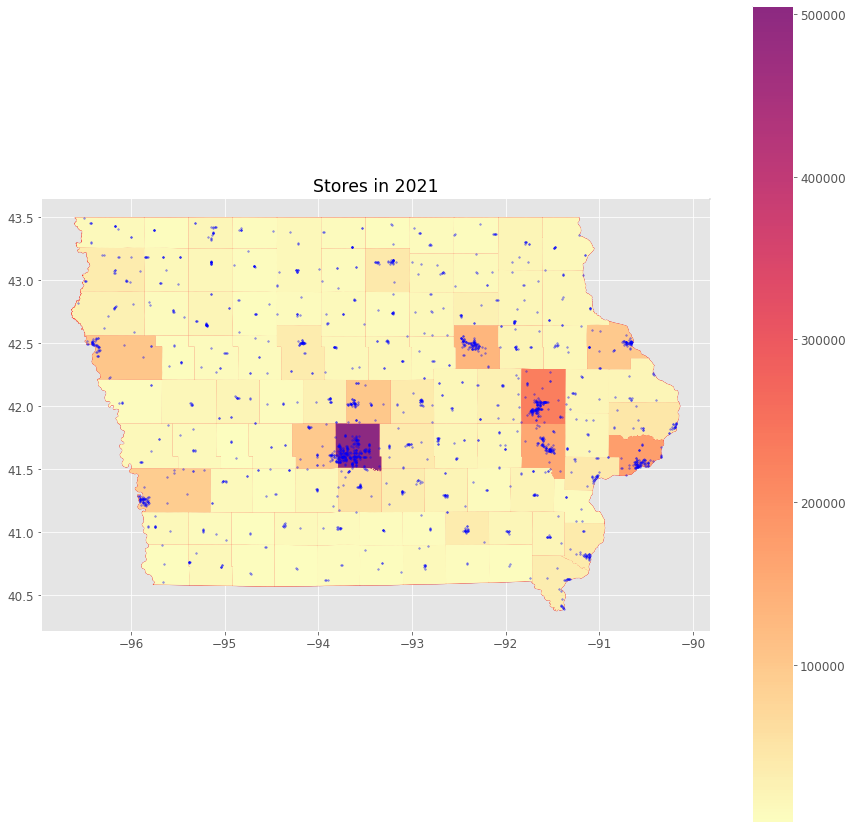

In [85]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('Stores in 2021')

map_counties.plot(color='white', edgecolor='red', ax=ax)
map_counties2.plot(column='Population', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

#for name in map_counties_pts['County']:
#    if name in ['polk','linn','black hawk','scott','johnson']:
#        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
#        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
#        plt.text(x,y,name, fontsize=14, horizontalalignment='center')
        
store_geo.plot(ax = ax, color="blue",markersize=3, alpha=0.40)


No handles with labels found to put in legend.


<AxesSubplot:>

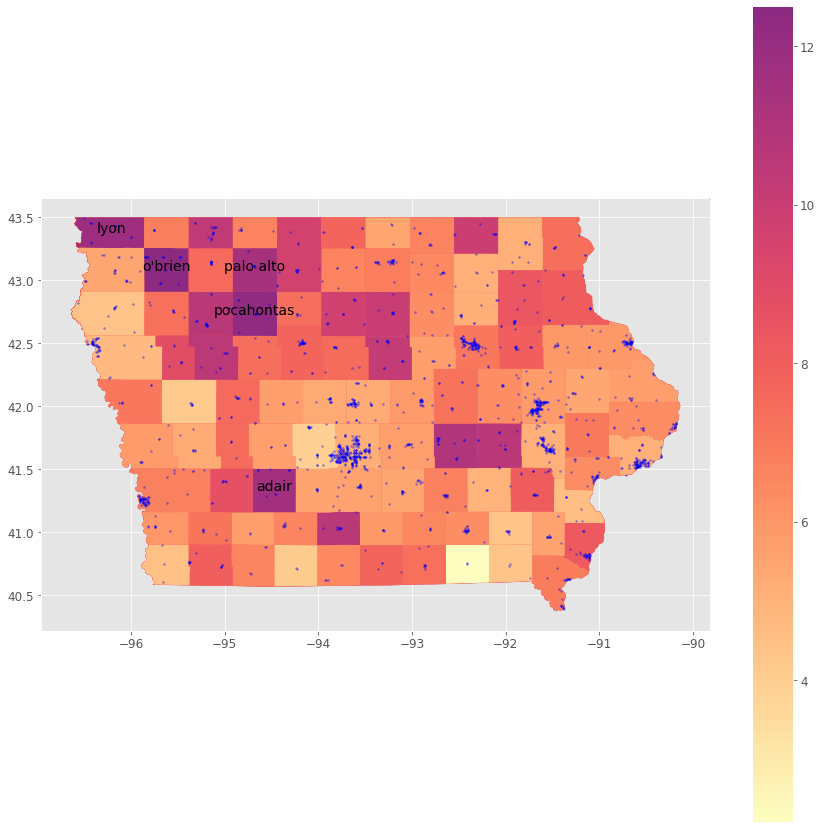

In [86]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

#ax.set_title('Stores per 10K Residents in 2021')

map_counties.plot(color='white', edgecolor='red', ax=ax)
map_counties2.plot(column='StoresPer10K', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

for name in map_counties_pts['County']:
    if name in ["o'brien",'pocahontas','lyon','adair','palo alto']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y,name, fontsize=14, horizontalalignment='center')

store_geo.plot(ax = ax, color="blue",markersize=3, alpha=0.40)


No handles with labels found to put in legend.


<AxesSubplot:>

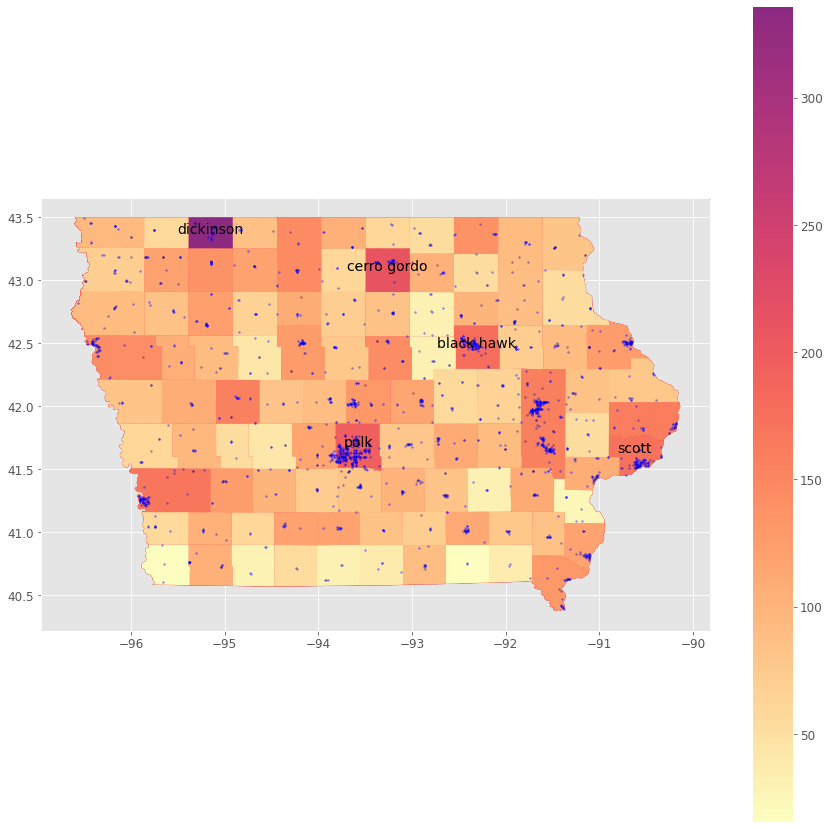

In [87]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

#ax.set_title('Sales per Capita in 2021')

map_counties.plot(color='white', edgecolor='red', ax=ax)
map_counties2.plot(column='SalesPerCapita', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

for name in map_counties_pts['County']:
    if name in ['dickinson','cerro gordo','polk','black hawk','scott']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y,name, fontsize=14, horizontalalignment='center')

store_geo.plot(ax = ax, color="blue",markersize=3, alpha=0.40)

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Volume Sold per Capita in 2021'}>

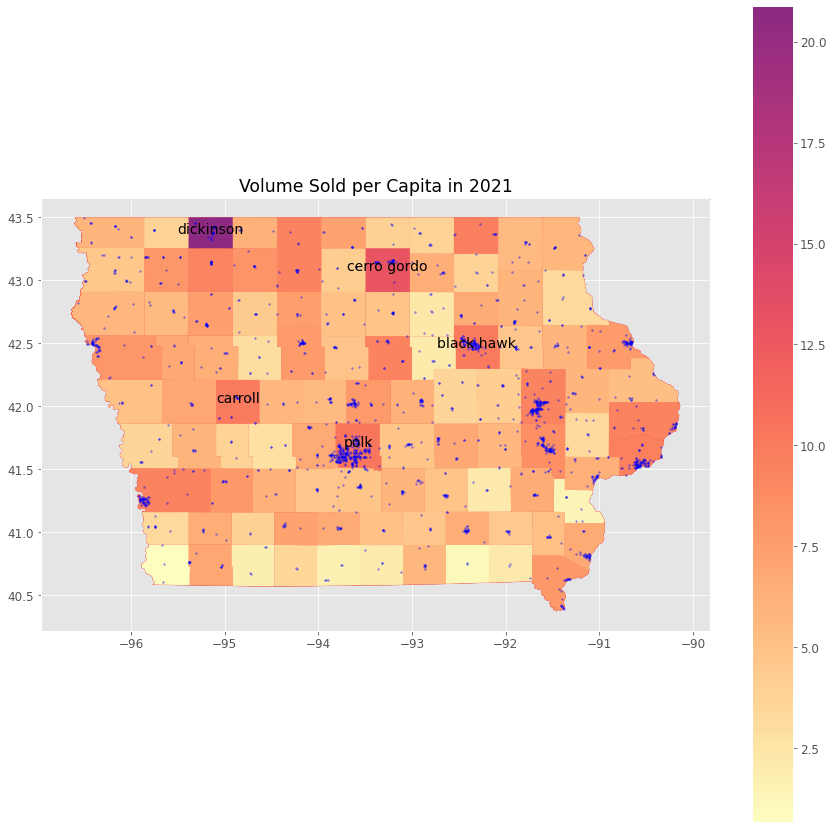

In [88]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('Volume Sold per Capita in 2021')

map_counties.plot(color='white', edgecolor='red', ax=ax)
map_counties2.plot(column='VolSoldPerCapita', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

for name in map_counties_pts['County']:
    if name in ['dickinson','cerro gordo','polk','black hawk','carroll']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y,name, fontsize=14, horizontalalignment='center')

store_geo.plot(ax = ax, color="blue",markersize=3, alpha=0.40)

No handles with labels found to put in legend.


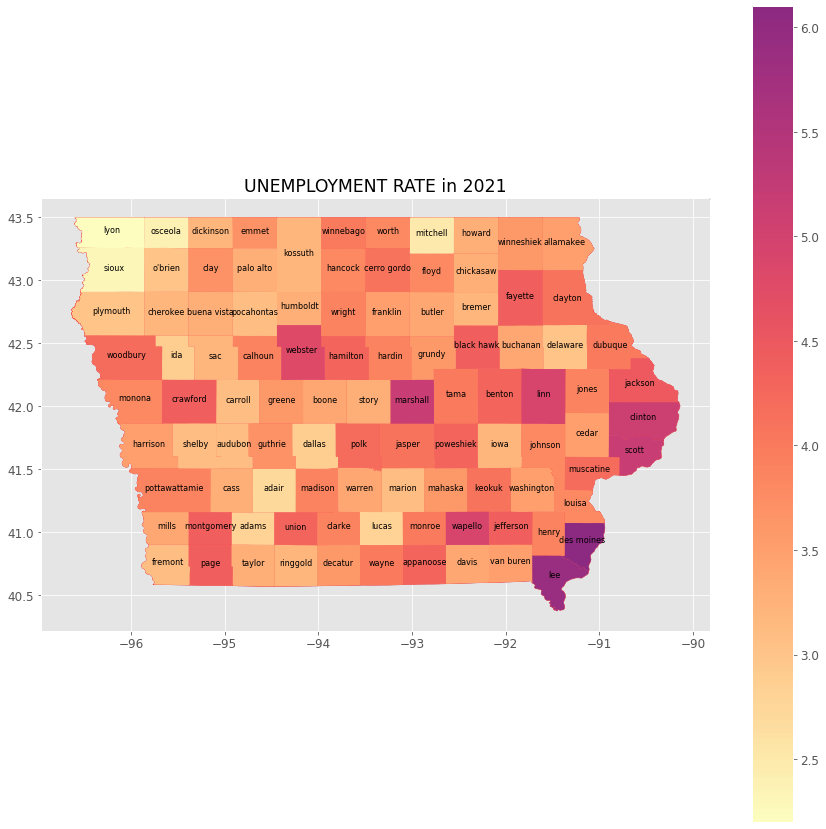

In [89]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('UNEMPLOYMENT RATE in 2021')

map_counties.plot(color='white', edgecolor='red', ax=ax)
map_counties2.plot(column='UNEMPLOYMENT_RATE', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

for name in map_counties_pts['County']:
    x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
    y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
    plt.text(x,y,name, fontsize=8, horizontalalignment='center')

No handles with labels found to put in legend.


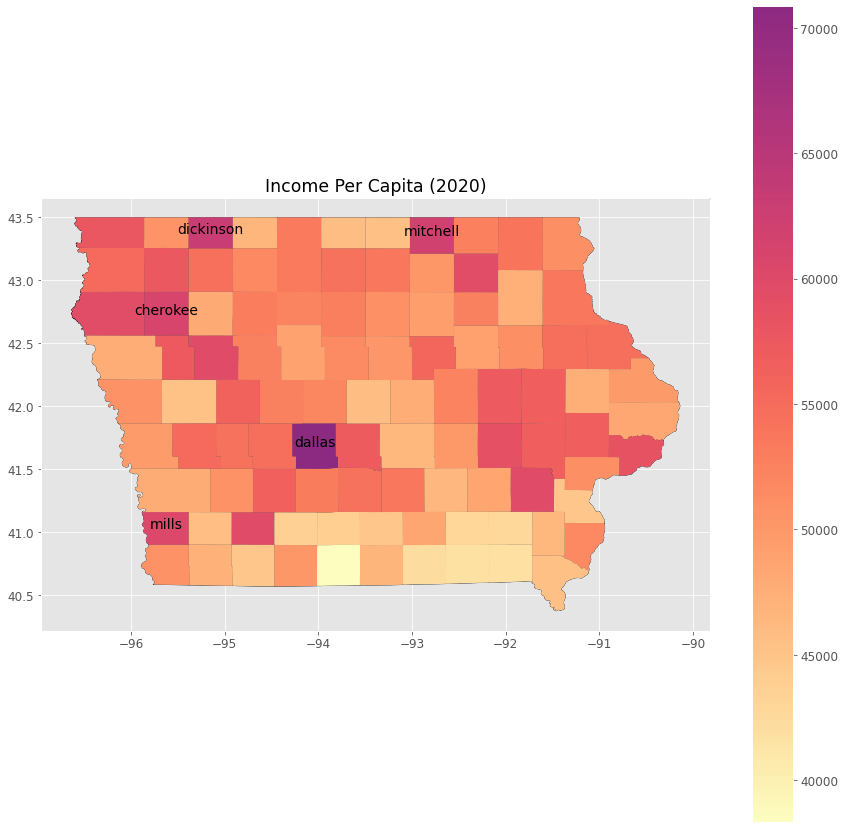

In [90]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('Income Per Capita (2020)')

map_counties.plot(color='white', edgecolor='black', ax=ax)
map_counties2.plot(column='Income_PerCapita_2020', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

for name in map_counties_pts['County']:
    if name in ['dallas','dickinson','mitchell','cherokee','mills']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y,name, fontsize=14, horizontalalignment='center')

No handles with labels found to put in legend.


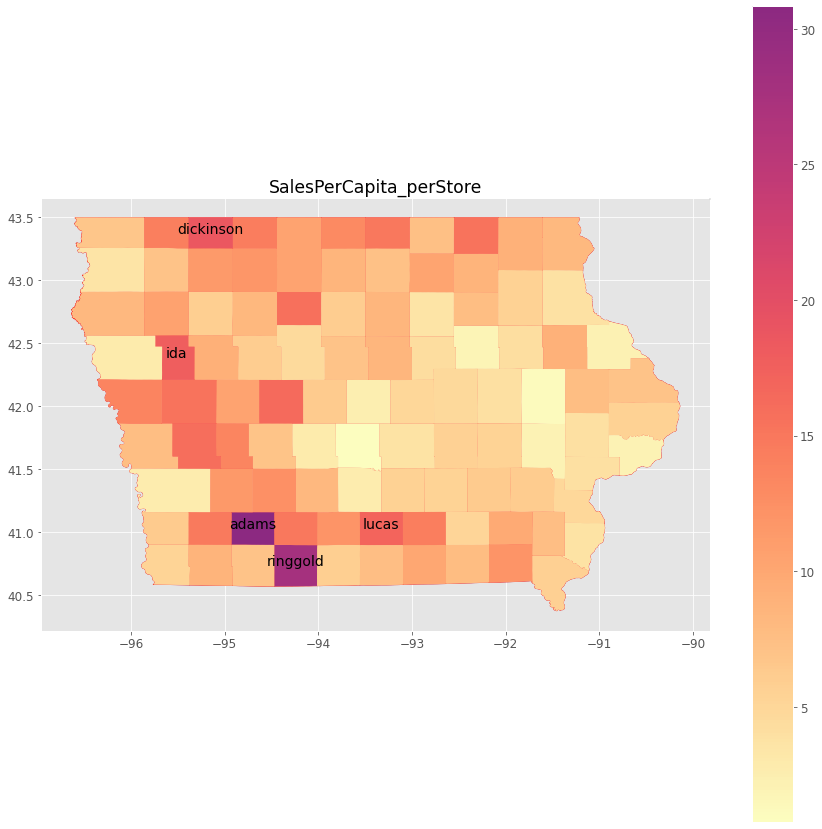

In [91]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')

ax.set_title('SalesPerCapita_perStore')

map_counties.plot(color='white', edgecolor='red', ax=ax)
map_counties2.plot(column='SalesPerCapita_perStore', cmap=new_cmap, ax=ax, legend=True)
ax.legend(prop={'size':1}, loc='best')

for name in map_counties_pts['County']:
    if name in ['adams','ringgold','dickinson','ida','lucas']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y,name, fontsize=14, horizontalalignment='center')

# Clustering

In [92]:
# Connect SQLite.
dbconn = sqlite3.connect('../data/IowaLiquorSales.db')
cursor = dbconn.cursor()

# Pull Store database.
query = '''SELECT Sales.Date, Sales.ProductID, Sales.StoreID, Sales.VolumeSold_Liters, Sales.Sale_Dollars, Store.County, Store.lat, Store.lng, Store.active, Product.CategoryGroup
              FROM ((Sales 
              INNER JOIN Product ON Sales.ProductID=Product.ProductID)
              INNER JOIN Store ON Sales.StoreID=Store.StoreID)
              WHERE Sales.Date BETWEEN '2017-01-01' AND '2021-12-31';'''
cursor.execute(query)
result2 = cursor.fetchall()
cursor.close()
dbconn.close()

In [93]:
# Put the database in a data frame format.
ctemp = pd.DataFrame(result2, columns = ['Date',
                                       'ProductID',
                                       'StoreID',
                                       'VolumeSold_Liters', 
                                       'Sale_Dollars', 
                                       'County', 
                                       'lat',
                                       'lng', 
                                       'active', 
                                       'CategoryGroup'])

In [94]:
ctemp.head()

,Date,ProductID,StoreID,VolumeSold_Liters,Sale_Dollars,County,lat,lng,active,CategoryGroup
0,2018-09-04,26826,4617,3.00,93.44,polk,41.60774,-93.57014,Active,whisky
1,2019-03-19,26826,2513,18.00,560.64,johnson,41.65143,-91.50105,Active,whisky
2,2019-05-15,86251,5068,12.00,43.56,dickinson,43.36136,-95.13954,Active,liqueur
3,2019-05-16,89566,2588,0.75,19.89,linn,41.97518,-91.60977,Active,tequila
4,2019-05-15,35926,2647,9.00,60.72,linn,41.93023,-91.71520,Active,vodka


In [95]:
ctemp['Date'] = pd.to_datetime(ctemp['Date'])
ctemp['Year'] = pd.to_datetime(ctemp['Date']).dt.year
ctemp['Month'] = pd.to_datetime(ctemp['Date']).dt.month

In [96]:
ctemp[ctemp['Year']==2021].groupby(['StoreID']).agg({'Sale_Dollars':'sum'})

,Sale_Dollars
StoreID,
2106,1033483.12
2130,1242342.77
2178,2933.14
2190,2629203.54
2191,1346072.45
...,...
9042,62948.64
9046,14850.00
9047,152177.40


In [97]:
store_db = ctemp[ctemp['Year']==2021].groupby(['StoreID','CategoryGroup']).agg(Sale=('Sale_Dollars','sum'),)
store_db.head(11)

Sale
StoreID CategoryGroup           
2106    brandy          10198.29
        cocktail         3206.16
        gin             20861.19
        liqueur        130662.88
        other           15169.98
        rum            163860.47
        schnapps        92111.10
        spirit           6442.04
        tequila         90231.03
        vodka          216803.31
        whisky         283936.67

In [98]:
test = store_db.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
test.head(11)

Sale
StoreID CategoryGroup           
2106    brandy          0.986788
        cocktail        0.310229
        gin             2.018532
        liqueur        12.642962
        other           1.467850
        rum            15.855167
        schnapps        8.912685
        spirit          0.623333
        tequila         8.730770
        vodka          20.977925
        whisky         27.473760

In [99]:
store_db = test.pivot_table(values='Sale', index='StoreID', columns=['CategoryGroup'], aggfunc=np.sum)
store_db.fillna(0, inplace=True)
store_db.head()

CategoryGroup,brandy,cocktail,gin,liqueur,other,rum,schnapps,spirit,tequila,vodka,whisky
StoreID,,,,,,,,,,,
2106,0.986788,0.310229,2.018532,12.642962,1.467850,15.855167,8.912685,0.623333,8.730770,20.977925,27.473760
2130,2.504228,0.269805,1.564018,9.709412,0.455361,13.522869,7.189972,0.589388,11.885890,18.132158,34.176899
2178,14.648806,1.125074,0.000000,14.356287,0.000000,1.641585,5.825839,8.898314,2.222533,28.309252,22.972310
2190,15.732358,0.457280,2.525124,4.830448,5.815045,3.618621,0.648016,1.782883,16.851135,10.922257,36.816834
2191,2.164636,0.114700,1.983892,10.107957,2.821367,10.921871,5.777452,2.766841,10.009062,17.507679,35.824543


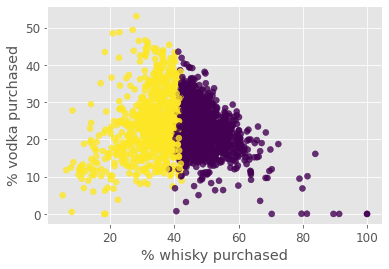

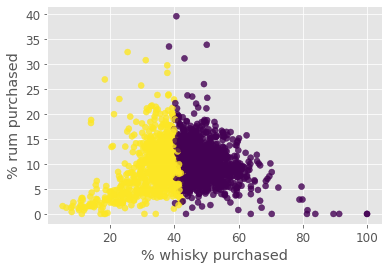

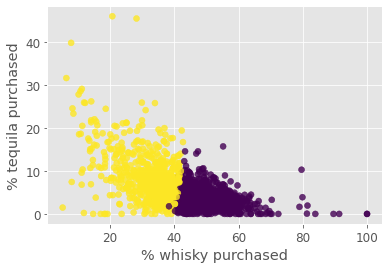

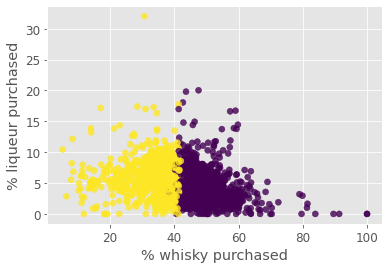

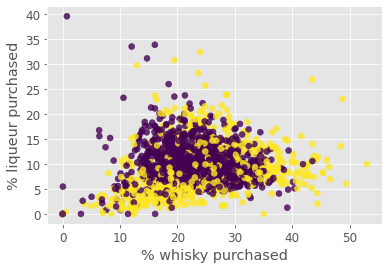

In [100]:
from sklearn.cluster import KMeans

kmeans = KMeans()

kmeans.set_params(n_clusters=2)
kmeans.fit(store_db[['whisky','vodka','rum','tequila','liqueur']])
kmeans.labels_

plt.scatter(store_db[['whisky']], store_db[['vodka']], c=kmeans.labels_, alpha=0.8)
plt.xlabel('% whisky purchased')
plt.ylabel('% vodka purchased')
plt.show()

plt.scatter(store_db[['whisky']], store_db[['rum']], c=kmeans.labels_, alpha=0.8)
plt.xlabel('% whisky purchased')
plt.ylabel('% rum purchased')
plt.show()

plt.scatter(store_db[['whisky']], store_db[['tequila']], c=kmeans.labels_, alpha=0.8)
plt.xlabel('% whisky purchased')
plt.ylabel('% tequila purchased')
plt.show()

plt.scatter(store_db[['whisky']], store_db[['liqueur']], c=kmeans.labels_, alpha=0.8)
plt.xlabel('% whisky purchased')
plt.ylabel('% liqueur purchased')
plt.show()

plt.scatter(store_db[['vodka']], store_db[['rum']], c=kmeans.labels_, alpha=0.8)
plt.xlabel('% whisky purchased')
plt.ylabel('% liqueur purchased')
plt.show()

In [101]:
store_db['cluster'] = kmeans.labels_

In [102]:
store_db.head()

CategoryGroup,brandy,cocktail,gin,liqueur,other,rum,schnapps,spirit,tequila,vodka,whisky,cluster
StoreID,,,,,,,,,,,,
2106,0.986788,0.310229,2.018532,12.642962,1.467850,15.855167,8.912685,0.623333,8.730770,20.977925,27.473760,1
2130,2.504228,0.269805,1.564018,9.709412,0.455361,13.522869,7.189972,0.589388,11.885890,18.132158,34.176899,1
2178,14.648806,1.125074,0.000000,14.356287,0.000000,1.641585,5.825839,8.898314,2.222533,28.309252,22.972310,1
2190,15.732358,0.457280,2.525124,4.830448,5.815045,3.618621,0.648016,1.782883,16.851135,10.922257,36.816834,1
2191,2.164636,0.114700,1.983892,10.107957,2.821367,10.921871,5.777452,2.766841,10.009062,17.507679,35.824543,1


In [103]:
store_db.loc[store_db['cluster']==0]

CategoryGroup,brandy,cocktail,gin,liqueur,other,rum,schnapps,spirit,tequila,vodka,whisky,cluster
StoreID,,,,,,,,,,,,
2200,1.769531,1.004272,1.483303,7.984397,4.466263,12.973571,3.816449,3.322353,6.849753,13.003133,43.326976,0
2228,1.656546,2.204264,1.731791,8.687414,3.281718,9.509438,2.685073,3.191303,5.500504,18.790178,42.761771,0
2233,2.188462,0.745809,2.963015,5.542891,2.522870,11.205299,2.648632,2.609104,4.673137,20.913847,43.986935,0
2445,3.429567,1.037080,2.446729,4.600534,2.907632,6.554646,2.012725,0.590279,2.297961,19.271583,54.851264,0
2459,1.746558,1.313243,1.088938,5.995846,2.623492,8.333762,1.464453,0.922353,3.204572,23.229532,50.077250,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9038,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.674232,0.000000,0.000000,91.325768,0
9042,0.000000,0.000000,0.000000,0.097794,0.000000,0.000000,0.000000,24.736738,0.000000,11.382422,63.783046,0
9046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0


In [104]:
store_geo2 = store_geo.merge(store_db, on = ['StoreID'], how = 'left')
store_geo2.head()

,StoreID,County,lat,lng,geometry,brandy,cocktail,gin,liqueur,other,rum,schnapps,spirit,tequila,vodka,whisky,cluster
0,5417,linn,41.88875,-91.67497,POINT (-91.67497 41.88875),2.511266,0.105253,0.541767,2.027667,2.043170,8.492647,1.188839,0.290478,8.579938,25.058130,49.160844,0
1,4921,linn,41.96451,-91.73978,POINT (-91.73978 41.96451),8.508635,0.431449,0.804143,3.079302,2.640757,9.176661,5.709675,0.034830,4.229546,18.946681,46.438322,0
2,5687,linn,41.96442,-91.72973,POINT (-91.72973 41.96442),5.155661,0.221612,0.419127,1.526032,0.775080,7.362557,1.495452,0.239975,8.018156,29.924107,44.862242,0
3,2648,polk,41.56108,-93.77478,POINT (-93.77478 41.56108),1.466849,3.089292,4.178054,8.016575,3.537514,7.402988,1.284880,1.579022,6.753960,23.540318,39.150549,1
4,4379,polk,41.58511,-93.78953,POINT (-93.78953 41.58511),4.148737,0.293836,0.747860,1.455113,1.575142,9.668578,0.000000,0.232371,1.583752,31.971836,48.322772,0


Text(0, 0.5, '% vodka purchased')

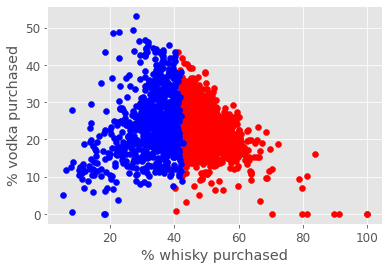

In [105]:
plt.scatter(store_geo2.loc[store_geo2['cluster']==0,'whisky'], 
            store_geo2.loc[store_geo2['cluster']==0, 'vodka'],color='red')
plt.scatter(store_geo2.loc[store_geo2['cluster']==1,'whisky'], 
            store_geo2.loc[store_geo2['cluster']==1, 'vodka'],color='blue')
plt.xlabel('% whisky purchased')
plt.ylabel('% vodka purchased')

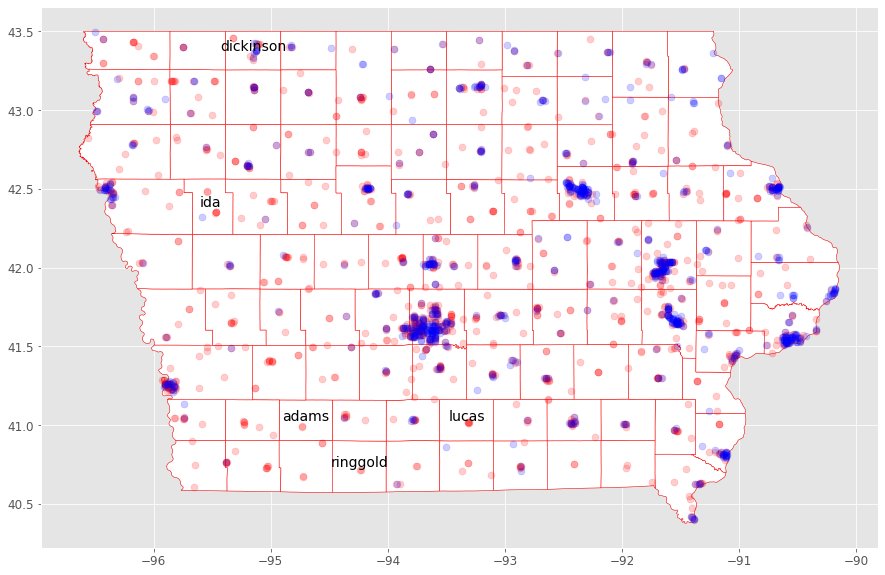

In [106]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')
map_counties.plot(color='white', edgecolor='red', ax=ax)

store_geo2.loc[store_geo2['cluster']==0].plot(ax = ax, color="red",markersize=50, alpha=0.20)
store_geo2.loc[store_geo2['cluster']==1].plot(ax = ax, color="blue",markersize=50, alpha=0.20)

for name in map_counties_pts['County']:
    if name in ['adams','ringgold','dickinson','ida','lucas']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y,name, fontsize=14, horizontalalignment='center')

(43.25, 43.51)

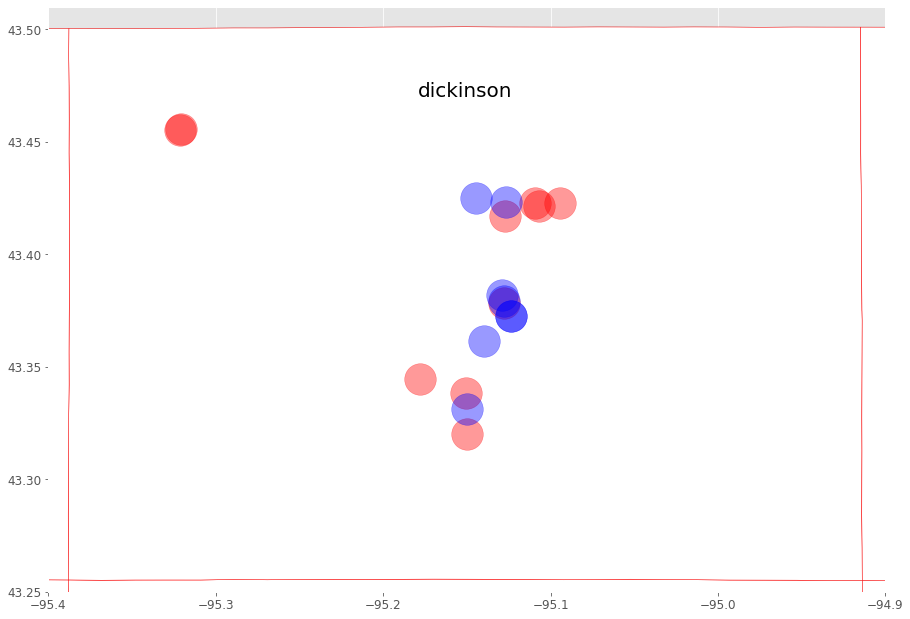

In [107]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')
map_counties.plot(color='white', edgecolor='red', ax=ax)

store_geo2.loc[store_geo2['cluster']==0].plot(ax = ax, color="red",markersize=1000, alpha=0.40)
store_geo2.loc[store_geo2['cluster']==1].plot(ax = ax, color="blue",markersize=1000, alpha=0.40)

for name in map_counties_pts['County']:
    #if name in ['adams','ringgold','dickinson','ida','lucas']:
    if name in ['dickinson']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,43.47,name, fontsize=20, horizontalalignment='center')
        
ax.set_xlim(-95.4,-94.9)
ax.set_ylim(43.25,43.51)


(42.19, 42.57)

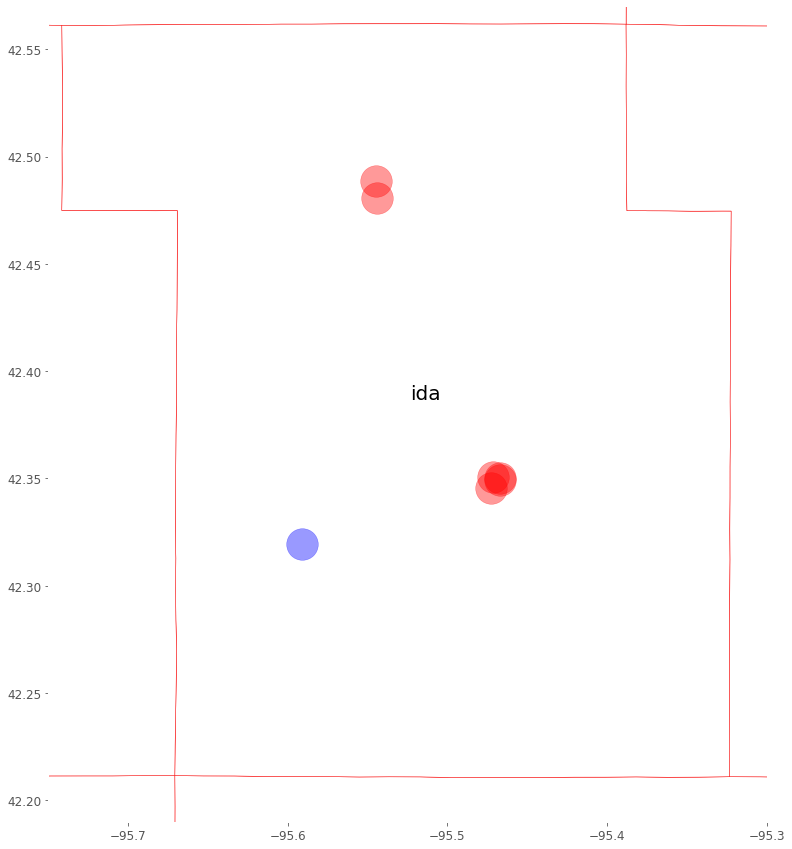

In [108]:
fig,ax = plt.subplots(figsize = (15,15))

# County Boundaries
map_counties2.to_crs(epsg=4326).plot(ax = ax, alpha=0.2, color="gray",edgecolor='black')
map_counties.plot(color='white', edgecolor='red', ax=ax)

store_geo2.loc[store_geo2['cluster']==0].plot(ax = ax, color="red",markersize=1000, alpha=0.40)
store_geo2.loc[store_geo2['cluster']==1].plot(ax = ax, color="blue",markersize=1000, alpha=0.40)

for name in map_counties_pts['County']:
    #if name in ['adams','ringgold','dickinson','ida','lucas']:
    if name in ['ida']:
        x = map_counties_pts.loc[map_counties_pts['County']==name,'primary_lo']
        y = map_counties_pts.loc[map_counties_pts['County']==name,'primary_la']
        plt.text(x,y,name, fontsize=20, horizontalalignment='center')
        
ax.set_xlim(-95.75,-95.3)
ax.set_ylim(42.19,42.57)

In [109]:
df_bycounty.head()

,County,Annual_SalesDollars,StoreCount,Annual_VolumeSold,ProductCount,VendorCount,Year,Population,LABORFORCE,EMPLOYMENT,UNEMPLOYMENT,UNEMPLOYMENT_RATE,StoresPer10K,SalesPerCapita,VolSoldPerCapita,Income_PerCapita_2020,SalesPerCapita_perStore
0,adair,683600.94,8,43177.07,621,52,2021,6888,4300,4180,120,2.7,11.614402,99.245200,6.268448,56422.0,12.405650
1,adams,215545.86,2,13532.61,445,48,2021,3496,2010,1950,60,2.8,5.720824,61.654994,3.870884,59569.0,30.827497
2,allamakee,1091295.24,10,77669.16,1155,66,2021,13548,7010,6760,250,3.5,7.381163,80.550283,5.732888,51107.0,8.055028
3,appanoose,1107116.79,9,71170.37,892,53,2021,12335,6060,5800,260,4.3,7.296311,89.754097,5.769791,42125.0,9.972677
4,audubon,288076.35,4,19729.46,642,53,2021,5338,3070,2970,90,3.1,7.493443,53.967094,3.696040,54313.0,13.491774


In [110]:
df_bycounty_org = df_bycounty[['County','Year','Annual_SalesDollars','StoreCount','ProductCount','VendorCount','StoresPer10K','SalesPerCapita','Income_PerCapita_2020','SalesPerCapita_perStore']]
df_bycounty_org.head(10)

,County,Year,Annual_SalesDollars,StoreCount,ProductCount,VendorCount,StoresPer10K,SalesPerCapita,Income_PerCapita_2020,SalesPerCapita_perStore
0,adair,2021,683600.94,8,621,52,11.614402,99.245200,56422.0,12.405650
1,adams,2021,215545.86,2,445,48,5.720824,61.654994,59569.0,30.827497
2,allamakee,2021,1091295.24,10,1155,66,7.381163,80.550283,51107.0,8.055028
3,appanoose,2021,1107116.79,9,892,53,7.296311,89.754097,42125.0,9.972677
4,audubon,2021,288076.35,4,642,53,7.493443,53.967094,54313.0,13.491774
5,benton,2021,1630504.83,16,1514,89,6.309895,64.301961,57277.0,4.018873
6,black hawk,2021,23562357.61,93,3205,163,7.053737,178.712561,49133.0,1.921640
7,boone,2021,2354170.45,14,1781,102,5.300822,89.135983,52028.0,6.366856
8,bremer,2021,2499718.40,13,1822,89,5.132254,98.686080,52608.0,7.591237
9,buchanan,2021,1501494.16,17,1253,76,8.002636,70.681832,51065.0,4.157755


In [113]:
table_to_compare = df_bycounty_org.sort_values(by = 'SalesPerCapita_perStore',ascending=False)
table_to_compare.head(5)

,County,Year,Annual_SalesDollars,StoreCount,ProductCount,VendorCount,StoresPer10K,SalesPerCapita,Income_PerCapita_2020,SalesPerCapita_perStore
1,adams,2021,215545.86,2,445,48,5.720824,61.654994,59569.0,30.827497
79,ringgold,2021,267877.77,2,483,34,4.132231,55.346647,50196.0,27.673323
29,dickinson,2021,5864449.26,18,2179,112,10.307507,335.821409,63319.0,18.656745
46,ida,2021,724164.12,6,1323,96,8.848252,106.793116,57429.0,17.798853
58,lucas,2021,719057.82,5,921,57,5.926980,85.236821,44707.0,17.047364


In [115]:
last_table = table_to_compare[['County','StoreCount','SalesPerCapita_perStore','ProductCount','VendorCount','Income_PerCapita_2020']]
last_table.head(5)

,County,StoreCount,SalesPerCapita_perStore,ProductCount,VendorCount,Income_PerCapita_2020
1,adams,2,30.827497,445,48,59569.0
79,ringgold,2,27.673323,483,34,50196.0
29,dickinson,18,18.656745,2179,112,63319.0
46,ida,6,17.798853,1323,96,57429.0
58,lucas,5,17.047364,921,57,44707.0


In [ ]:
# top candidates are dickinson and ida